In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import string
import nltk
import re

# preprocessing
from gensim.models import KeyedVectors
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Input , Embedding, Conv1D , MaxPooling1D, Dropout, LSTM, Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Load the data
DEPRESSIVE_TWEETS_CSV = '/content/drive/MyDrive/Depressing social post detection/depressive_tweets.csv'
RANDOM_TWEETS_CSV = '/content/drive/MyDrive/Depressing social post detection/Suicide_Detection.csv'
EMBEDDING_FILE = '/content/drive/MyDrive/Depressing social post detection/GoogleNews-vectors-negative300.bin'
# the google new vector .. has word vectors of 300DIM for words. Trained on massive amount of google news.

In [ ]:
TWEETS = pd.read_csv(RANDOM_TWEETS_CSV , nrows=5000 , usecols = range(1,3))

In [ ]:
TWEETS.head()

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [ ]:
TWEETS.groupby('class').describe()

text                                                            \
            count unique                                                top   
class                                                                         
non-suicide  2531   2531  Am I weird I don't get affected by compliments...   
suicide      2469   2469  Ex Wife Threatening SuicideRecently I left my ...   

                  
            freq  
class             
non-suicide    1  
suicide        1

In [ ]:
# Let's get the average seq length to be able to set a reasonable max_seq_length
TWEETS['length'] = TWEETS['text'].apply(len)

<Axes: xlabel='class', ylabel='length'>

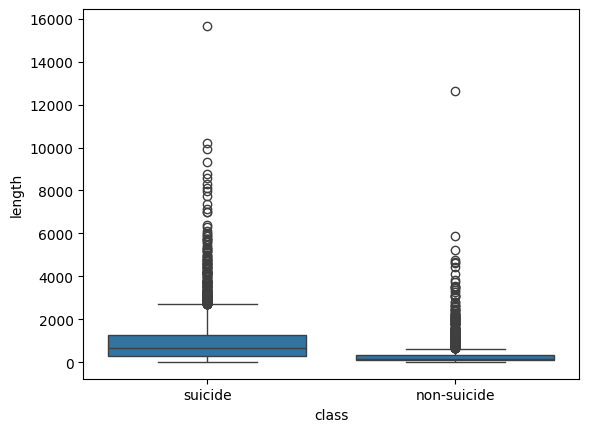

In [ ]:
sns.boxplot(x = 'class' , y = 'length' , data=TWEETS)

In [ ]:
TWEETS.groupby('class')['length'].median()

class
non-suicide    168.0
suicide        641.0
Name: length, dtype: float64

In [ ]:
# Some parameters
np.random.seed(101)
max_seq_length = 200
max_nb_words = 10000
embedding_dim = 300
learning_rate =0.1

In [ ]:
#Import the word Embeddings
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary = True)

In [ ]:
word2vec['Zara'].size

300

In [ ]:
# Let's clean the text
# remove punk
#remove hashtags and emojies and urls
#for missing values null_idx = df.dropna(axis=0 , inplace = true)
def clean_tweets(tweets):
  cleaned=[]
  for tweet in tweets:
    tweet = ' '.join(re.sub('(#[0-9A-Za-z]+)',' ',tweet).split())
    tweet = ' '.join(re.sub('([^0-9a-zA-Z \t])',' ',tweet).split())
    tweet_token = nltk.word_tokenize(tweet)
    tweet_nostop = [word for word in tweet_token if word.lower() not in stopwords.words('english')]
    tweet = ' '.join(tweet_nostop)
    #tweet = PorterStemmer().stem(tweet)
    cleaned.append(tweet)
  return cleaned




In [ ]:
clean_tweets(["I'm a girl in US living alone."])

['girl US living alone']

In [ ]:
# Lets apply it to our data
TWEETS_arr = [tweet for tweet in TWEETS['text']]
X = clean_tweets(TWEETS_arr)

In [ ]:
len(X)

5000

In [ ]:
tokenizer = Tokenizer(max_nb_words)
tokenizer.fit_on_texts(X)

In [ ]:
# now convert the tweets into vecotrs of numbers
X_vec = tokenizer.texts_to_sequences(X)

In [ ]:
# let's see how many words we tokenized to
word_index = tokenizer.word_index
len(word_index)

19462

In [ ]:
X_vec[1] # so now element 1 is a vector
# now X is an array of 5000 vectors each representing numbers

[356, 7, 2835, 5055, 338, 24, 4, 1722, 5, 13, 30, 713, 1310]

In [ ]:
# Create the input to the CNN mode so we pad
X_data = pad_sequences(X_vec , maxlen = max_seq_length)
print(X_data.shape) # this is now each row is one example and each column is a word

(5000, 200)


In [ ]:
# Let's create embeddings
nb_words = min(max_nb_words,len(word_index))

embedding_matrix = np.zeros((nb_words , embedding_dim))
for (word , idx) in word_index.items():
  if word in word2vec.key_to_index and idx<max_nb_words:
    embedding_matrix[idx] = word2vec.word_vec(word)

<ipython-input-39-d5716d6271c6>:7: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  embedding_matrix[idx] = word2vec.word_vec(word)


In [ ]:
embedding_matrix.shape

(10000, 300)

In [ ]:
len(embedding_matrix)

10000

In [ ]:
# create the y labels
y_label=TWEETS['class']
y = []
for item in y_label:
  if item=='suicide':
    y.append(1)
  else:
    y.append(0)

In [ ]:
y = np.array(y)

## Let's build our attention model first


In [ ]:
# the positional encoding matrix will be added to X
import tensorflow as tf
from tensorflow.keras import layers , Model

In [ ]:
max_seq_length = 200
max_nb_words = 10000
vocab_size = 10000
embedding_dim = 300
num_heads = 10
num_classes = 2

In [ ]:
# x, _ = MultiHeadSelfAttention(d_model=embedding_dim, num_heads=num_heads)(x, x, x, mask)
class MultiHeadSelfAttention(layers.Layer):
  def __init__(self, d_model,num_heads):
    super(MultiHeadSelfAttention,self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    # since the embd_dim =300 let do 10 attention heads
    assert d_model % self.num_heads==0
    self.head_dim = d_model // self.num_heads
    self.wq = layers.Dense(d_model)
    self.wk = layers.Dense(d_model)
    self.wv = layers.Dense(d_model)
    self.dense = layers.Dense(d_model)

  def split_heads(self, x , batch_size):
    x = tf.reshape(x ,(batch_size , -1 , self.num_heads , self.head_dim))
    return tf.transpose(x , perm = [0,2,1,3])

  def call(self , v , k , q ,mask=None):
    batch_size = tf.shape(q)[0]
    q = self.wq(q)
    k = self.wk(k)
    v = self.wv(v)
    q = self.split_heads(q , batch_size)
    k = self.split_heads(k , batch_size)
    v = self.split_heads(v , batch_size)
    s_att , att_w = self.scaled_attention(q,k,v,mask)
    s_att = tf.transpose(s_att , perm = [0,2,1,3])
    concat_att = tf.reshape(s_att , (batch_size , -1 , self.d_model))
    out_put = self.dense(concat_att)
    return out_put , att_w

  def scaled_attention(self , q ,k ,v , mask=None):
    qk = tf.matmul(q , k , transpose_b=True)
    #dk = tf.shape(k)[-1]
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled = qk / tf.math.sqrt(dk)
    attention_w = tf.nn.softmax(scaled, axis=-1)
    out_put = tf.matmul(attention_w,v)
    return out_put , attention_w


In [ ]:
# Implement the positional embedding mine
#positional encoding in keras
import tensorflow as tf

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_seq_length, embedding_dim):
        super(PositionalEncoding, self).__init__()
        self.max_seq_length = max_seq_length
        self.embedding_dim = embedding_dim

    def call(self, x):
        batch_size = tf.shape(x)[0]
        even_i = tf.range(0, self.embedding_dim, 2)
        even_i = tf.cast(even_i, dtype=tf.float32)
        denominator = tf.pow(10000.0, even_i /self.embedding_dim)
        # Get the angles
        position = tf.range(self.max_seq_length, dtype=tf.float32)[:, tf.newaxis]
        sines = tf.math.sin(position/denominator)
        cosines = tf.math.cos(position/denominator)
        stacked = tf.stack([sines, cosines], axis=-1)
        #print('Position encodings staked',stacked)
        #print('PE shape',tf.shape(stacked))
        PE = tf.keras.layers.Flatten()(stacked)
        PE = tf.reshape(PE ,(batch_size,max_seq_length,-1))
        #print('Position encodings',PE)
        #print('PE shape',tf.shape(PE))
        # Add positional encoding to the input embeddings
        return PE

In [ ]:
pe = PositionalEncoding(max_seq_length=10 , embedding_dim=6)
pe.call()

<tf.Tensor: shape=(10, 6), dtype=float32, numpy=
array([[ 0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
         1.        ],
       [ 0.84147096,  0.5403023 ,  0.04639922,  0.998923  ,  0.00215443,
         0.9999977 ],
       [ 0.9092974 , -0.4161468 ,  0.09269849,  0.9956942 ,  0.00430886,
         0.9999907 ],
       [ 0.14112   , -0.9899925 ,  0.13879807,  0.9903207 ,  0.00646326,
         0.99997914],
       [-0.7568025 , -0.6536436 ,  0.18459871,  0.98281395,  0.00861763,
         0.99996287],
       [-0.9589243 ,  0.28366217,  0.23000169,  0.97319025,  0.01077196,
         0.999942  ],
       [-0.2794155 ,  0.96017027,  0.27490923,  0.9614702 ,  0.01292625,
         0.99991643],
       [ 0.6569866 ,  0.75390226,  0.31922463,  0.9476791 ,  0.01508047,
         0.9998863 ],
       [ 0.98935825, -0.14550003,  0.3628524 ,  0.9318466 ,  0.01723462,
         0.99985147],
       [ 0.4121185 , -0.91113025,  0.4056985 ,  0.91400695,  0.01938869,
         0.999812  ]], 

In [ ]:
# Layer normalization
class LayerNormalization(layers.Layer):
    def __init__(self, input_shape, epsilon=1e-6):
        super(LayerNormalization, self).__init__()
        self.epsilon = epsilon
        self.gamma = self.add_weight(name='gamma', shape=(input_shape[-1],), initializer='ones', trainable=True)
        self.beta = self.add_weight(name='beta', shape=(input_shape[-1],), initializer='zeros', trainable=True)


    def call(self, x):
        mean = tf.reduce_mean(x, axis=-1, keepdims=True)
        variance = tf.reduce_mean(tf.square(x - mean), axis=-1, keepdims=True)
        normalized = (x - mean) / tf.sqrt(variance + self.epsilon)
        return self.gamma * normalized + self.beta

In [ ]:
"""input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 30
sequence_length = 5
x = tf.random.normal( (batch_size, sequence_length, input_dim) )

model = MultiHeadSelfAttention(d_model, num_heads)
out = model.call(x , x , x)

v.size(): [ 30   5 512]
v.size(): [30  8  5 64]
s_att.size(): [30  5  8 64]
out_put.size(): [ 30   5 512]


In [ ]:
from keras.layers import Reshape
def create_model(max_seq_length, vocab_size, embedding_dim, num_heads, num_classes ,embedding_matrix):
  inputs = layers.Input(shape = (max_seq_length,))
  x = layers.Embedding(max_nb_words , embedding_dim, weights=[embedding_matrix],input_length = max_seq_length, trainable = False )(inputs)
  #x = PositionalEncoding(max_seq_length, embedding_dim)(x)
  x, _ = MultiHeadSelfAttention(d_model=embedding_dim, num_heads=num_heads)(x, x, x , mask=None)
  #x_batch = x[0]
  #x = LayerNormalization(input_shape=(embedding_dim,))(x)
  x = layers.GlobalMaxPooling1D()(x)
  #x = layers.GlobalAveragePooling1D()(x)
  #x = layers.Dense(64, activation='relu')(x)
  #x = layers.Dropout(0.5)(x)
  #x = layers.Dropout(0.2)(x)
  #x = Reshape((-1, embedding_dim))(x)
  #x = layers.LSTM(64)(x)
  #x = layers.Dropout(0.2)(x)
  outputs = layers.Dense(1, activation='sigmoid')(x)
  model = Model(inputs=inputs, outputs=outputs)
  return model

In [ ]:
def create_model(max_seq_length, vocab_size, embedding_dim, num_heads, num_classes ,embedding_matrix):
  inputs = layers.Input(shape = (max_seq_length,))
  x = layers.Embedding(max_nb_words , embedding_dim, weights=[embedding_matrix],input_length = max_seq_length, trainable = False )(inputs)
  x, _ = MultiHeadSelfAttention(d_model=embedding_dim, num_heads=num_heads)(x, x, x , mask=None)
  x = layers.GlobalMaxPooling1D()(x)
  outputs = layers.Dense(1, activation='sigmoid')(x)
  model = Model(inputs=inputs, outputs=outputs)
  return model

In [ ]:
model = create_model(max_seq_length, vocab_size, embedding_dim, num_heads, num_classes,embedding_matrix)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_27 (InputLayer)       [(None, 200)]                0         []                            
                                                                                                  
 embedding_26 (Embedding)    (None, 200, 300)             3000000   ['input_27[0][0]']            
                                                                                                  
 multi_head_self_attention_  ((None, None, 300),          361200    ['embedding_26[0][0]',        
 22 (MultiHeadSelfAttention   (None, 10, None, None))                'embedding_26[0][0]',        
 )                                                                   'embedding_26[0][0]']        
                                                                                            

In [ ]:
# train , 0.8 , dev 0.1 test 0.1
X_train , X_temp , y_train , y_temp = train_test_split(X_data, y , test_size = 0.2 , random_state = 101)

X_val , X_test  , y_val , y_test = train_test_split(X_temp , y_temp , test_size = 0.5 , random_state = 101)

### Wandb

In [ ]:
#pip install wandb

In [ ]:
import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [ ]:
from wandb.keras import WandbCallback

wandb.init(project='Depression_detection_attention2', entity='zahra_amini')

acc,▁▇▆█▄
epoch,▁▃▅▆█
loss,█▁▁▁▁
val_acc,█▃▆▃▁
val_loss,▂▃▁▁█
acc,0.60175
best_epoch,2
best_val_loss,0.61436
epoch,4
loss,2.6167
val_acc,0.498


Build the model and then train

In [ ]:
from tensorflow.keras.optimizers import Adam
learning_rate = 0.1
optimizer = Adam(learning_rate = learning_rate)
model.compile(loss='binary_crossentropy', optimizer = 'adam' , metrics=['acc'])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_27 (InputLayer)       [(None, 200)]                0         []                            
                                                                                                  
 embedding_26 (Embedding)    (None, 200, 300)             3000000   ['input_27[0][0]']            
                                                                                                  
 multi_head_self_attention_  ((None, None, 300),          361200    ['embedding_26[0][0]',        
 22 (MultiHeadSelfAttention   (None, 10, None, None))                'embedding_26[0][0]',        
 )                                                                   'embedding_26[0][0]']        
                                                                                            

In [ ]:
early_stop = EarlyStopping(monitor = 'val_loss' , patience = 3)
hist = model.fit(X_train,y_train, validation_data = (X_val ,y_val),epochs = 5 , batch_size = 40, shuffle = True ,callbacks=[early_stop , WandbCallback()])

Epoch 1/5
100/100 [==============================] - ETA: 0s - loss: 0.3909 - acc: 0.8177

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240414_222359-w3ilalsh/files/model-best)... Done. 0.1s


100/100 [==============================] - 76s 747ms/step - loss: 0.3909 - acc: 0.8177 - val_loss: 0.3126 - val_acc: 0.8980
Epoch 2/5
100/100 [==============================] - ETA: 0s - loss: 0.2846 - acc: 0.8863

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240414_222359-w3ilalsh/files/model-best)... Done. 0.1s


100/100 [==============================] - 72s 716ms/step - loss: 0.2846 - acc: 0.8863 - val_loss: 0.2786 - val_acc: 0.9120
Epoch 3/5
100/100 [==============================] - 72s 720ms/step - loss: 0.2670 - acc: 0.9010 - val_loss: 0.2900 - val_acc: 0.8980
Epoch 4/5
100/100 [==============================] - ETA: 0s - loss: 0.2401 - acc: 0.9087

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240414_222359-w3ilalsh/files/model-best)... Done. 0.1s


100/100 [==============================] - 74s 738ms/step - loss: 0.2401 - acc: 0.9087 - val_loss: 0.2481 - val_acc: 0.9280
Epoch 5/5
100/100 [==============================] - 72s 716ms/step - loss: 0.2063 - acc: 0.9243 - val_loss: 0.2658 - val_acc: 0.9060


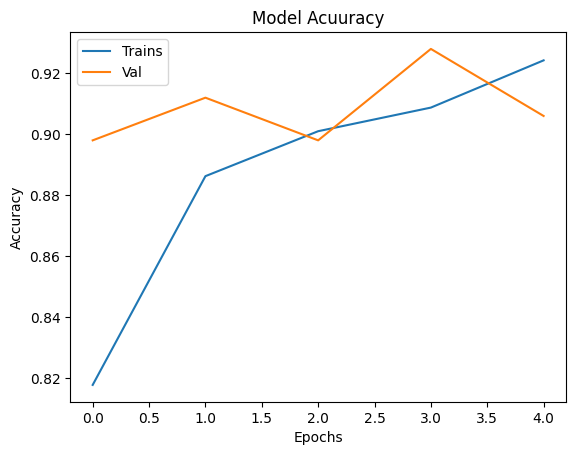

In [ ]:
# Save the model weights and load them to train more
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model Acuuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Trains','Val'])
plt.show()

In [ ]:
predictions = model.predict(X_test)
pred_binary = (predictions > 0.5).astype(int)

16/16 [==============================] - 4s 208ms/step


In [ ]:
from sklearn.metrics import classification_report , confusion_matrix
print(confusion_matrix(y_test , pred_binary))
print(classification_report(y_test,pred_binary))

[[234  19]
 [ 31 216]]
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       253
           1       0.92      0.87      0.90       247

    accuracy                           0.90       500
   macro avg       0.90      0.90      0.90       500
weighted avg       0.90      0.90      0.90       500

